In [1]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [3]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0000000000000036)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 216]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617644
(change of -0.12310562561763838)
Current ansatz: [241, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200767302
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.4850710481676663)]
Initial energy: -6.123105625617644
Optimizing energy with indices [241, 79, 216, 180]...
Starting point: [np.float64(-0.7853981624814353), np.float64(0.7853981626766198), np.float64(-0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689605)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 210]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.12248869758311001), np.float64(0.0)]

Current energy: -6.327276154816644
(change of -0.20417052920599765)
Current ansatz: [225, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964056416012
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.089491640726016)]
Initial energy: -6.327276154816644
Optimizing energy with indices [225, 79, 228, 210, 108]...
Starting point: [np.float64(0.7853984379184568), np.float64(0.7853991591701261), np.float64(0.16357028929940762), np.float64(0.16356997348722394), np.float64(0.0)]

Current energy: -6.464101614714416
(change of -0.1368254598977714)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 147]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615134789
(change of -0.13682546031508203)
Current ansatz: [241, 79, 228, 147, 135]
Performing final convergence check...
Total gradient norm: 2.784127796914466e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625805317495 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.0000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansatz: [241, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926737891)]
Initial energy: -6.327276154819709
Optimizing energy with indices [244, 79, 225, 210, 198]...
Starting point: [np.float64(0.7853981700346647), np.float64(0.7853981900506334), np.float64(-0.1635701974085294), np.float64(0.16356963668219085), np.float64(0.0)]

Current energy: -6.464101614835283
(change of -0.13682546001557316)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531783
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734875)]
Initial energy: -6.327276154819699
Optimizing energy with indices [244, 79, 228, 147, 210]...
Starting point: [np.float64(0.7853981646904773

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819981
(change of -0.20417052920233836)
Current ansatz: [244, 31, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964044040272
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491641532528)]
Initial energy: -6.327276154819981
Optimizing energy with indices [244, 31, 228, 135, 198]...
Starting point: [np.float64(0.7853981435358092), np.float64(-0.785398170851247), np.float64(0.16357028664718481), np.float64(0.163569972553437), np.float64(0.0)]

Current energy: -6.4641016150718675
(change of -0.13682546025188635)
Current ansatz: [244, 31, 228, 135, 198]
Performing final convergence check...
Total gradient norm: 0.0001356307986973241

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044040272 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200769645
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481689684)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 201]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819717
(change of -0.20417052920206658)
Current ansatz: [244, 26, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531816
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.089492926735053)]
Initial energy: -6.327276154819717
Optimizing energy with indices [244, 26, 216, 201, 225]...
Starting point: [np.float64(0.7853981655845017), np.float64(0.7853981631891999), np.float64(-0.1635701974084041), np.float64(0.16356963668284277), np.float64(0.0)]

Current energy: -6.464101615135244
(change of -0.136825460315527)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 2.6317552139192693e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531816 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [211]
Gradients: [np.float64(4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [211]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operator(s) added to ansatz: [241]
Gradients: [np.float64(3.4142135623691776)]
Initial energy: -3.828427124746197
Optimizing energy with indices [211, 241]...
Starting point: [np.float64(-0.3926990817001106), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917530720141803
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485073566996777)]
Initial energy: -6.123105625614734
Optimizing energy with indices [211, 241, 79, 228]...
Starting point: [np.float64(-0.122489928621197), np.float64(-0.7853981633782835), np.float64(0.7853981632897755), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548199945
(change of -0.20417052920526046)
Current ansatz: [211, 241, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042410849
Operator(s) added to ansatz: [39]
Gradients: [np.float64(2.08949164333104)]
Initial energy: -6.3272761548199945
Optimizing energy with indices [211, 241, 79, 228, 39]...
Starting point: [np.float64(-0.16357028661738654), np.float64(-0.78539816592175), np.float64(0.7853981640511413), np.float64(0.1635699721099399), np.float64(0.0)]

Current energy: -6.464101615072779
(change of -0.1368254602527843)
Current ansatz: [211, 241, 79, 228, 39]
Performing final convergence check...
Total gradient norm: 0.00013504335827546274

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042410849 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999475319
(change of -1.3737154598403505)
Current ansatz: [210, 225, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958972842304
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.999999997372934)]
Initial energy: -5.999999999475319
Optimizing energy with indices [210, 225, 79, 225]...
Starting point: [np.float64(3.907396708575578e-07), np.float64(0.7854096986521439), np.float64(0.7854095118363903), np.float64(0.0)]

Current energy: -6.12310562502166
(change of -0.12310562554634075)
Current ansatz: [210, 225, 79, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917481405077815
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850460778626235)]
Initial energy: -6.12310562502166
Optimizing energy with indices [210, 225, 79, 225, 198]...
Starting point: [np.float64(-6.520949166634536e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [225, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944214)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 228]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610647
(change of -0.12310562561245852)
Current ansatz: [225, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689605)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 210]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 198]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819986
(change of -0.20417052920233836)
Current ansatz: [241, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964058377264
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089491628942171)]
Initial energy: -6.327276154819986
Optimizing energy with indices [241, 79, 225, 198, 120]...
Starting point: [np.float64(-0.7853981662933148), np.float64(0.7853981545803549), np.float64(-0.16357028752134434), np.float64(-0.16356997584374114), np.float64(0.0)]

Current energy: -6.464101615072514
(change of -0.1368254602525285)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013521654536773468

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964058377264 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 79]...
Starting point: [np.float64(-0.5535743588970451), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.123105625562494
Optimizing energy with indices [228, 79, 225, 210]...
Starting point: [np.float64(-0.7853947065772614), np.float64(0.7853985308794381), np.float64(-0.12248927961669928), np.float64(0.0)]

Current energy: -6.327276154764743
(change of -0.20417052920224865)
Current ansatz: [228, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581220501
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089492926730274)]
Initial energy: -6.327276154764743
Optimizing energy with indices [228, 79, 225, 210, 147]...
Starting point: [np.float64(-0.7853947065771463), np.float64(0.7853982468607466), np.float64(-0.16357019741059903), np.float64(0.16356963668331825), np.float64(0.0)]

Current energy: -6.464101615080619
(change of -0.13682546031587606)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998192
(change of -1.763932022498393)
Current ansatz: [225, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140577
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0000000000024807)]
Initial energy: -5.999999999998192
Optimizing energy with indices [225, 26, 210]...
Starting point: [np.float64(0.7853985607314246), np.float64(0.7853989420959444), np.float64(0.0)]

Current energy: -6.123105625156513
(change of -0.12310562515832135)
Current ansatz: [225, 26, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917524648060677
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485070180376483)]
Initial energy: -6.123105625156513
Optimizing energy with indices [225, 26, 210, 225]...
Starting point: [np.float64(0.785408359434826), np.float64(0.7854119606462744), np.float64(0.1224890

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000006)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 216]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.1231056256176366)
Current ansatz: [244, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200769645
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048168968)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 225]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920233658)
Current ansatz: [244, 26, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200950523
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710482697833)]
Initial energy: -6.123105625617642
Optimizing energy with indices [244, 74, 216, 201]...
Starting point: [np.float64(0.7853981633664252), np.float64(-0.7853981637522963), np.float64(-0.12248927956001943), np.float64(0.0)]

Current energy: -6.327276154819711
(change of -0.20417052920206924)
Current ansatz: [244, 74, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625805319315
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894929267348825)]
Initial energy: -6.327276154819711
Optimizing energy with indices [244, 74, 216, 201, 225]...
Starting point: [np.float64(0.7853981645688155), np.float64(-0.7853981638711386), np.float64(-0.16357019740839865), np.float64(0.16356963668288213), np.float64(0.0)]

Current energy: -6.464101615135387
(change of -0.13682546031567622)
Curren

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000005)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.485071048168266)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 180]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944214)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 228]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610647
(change of -0.12310562561245852)
Current ansatz: [225, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.485068789862032)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 120]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 147]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819989
(change of -0.2041705292023419)
Current ansatz: [241, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042617831
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.08949164278134)]
Initial energy: -6.327276154819989
Optimizing energy with indices [241, 79, 225, 147, 135]...
Starting point: [np.float64(-0.7853981633974467), np.float64(0.7853981633974486), np.float64(-0.16357028656039646), np.float64(-0.16356997222705624), np.float64(0.0)]

Current energy: -6.4641016150727975
(change of -0.13682546025280828)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734934)]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 210]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615134318
(change of -0.1368254603146104)
Current ansatz: [241, 79, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 2.9260899740755612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.0000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929516
(change of -1.7639320224297173)
Current ansatz: [225, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647983
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000019367)]
Initial energy: -5.999999999929516
Optimizing energy with indices [225, 31, 228]...
Starting point: [np.float64(0.7853947065773541), np.float64(-0.7853993777262479), np.float64(0.0)]

Current energy: -6.123105625562488
(change of -0.1231056256329719)
Current ansatz: [225, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775825
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.123105625562488
Optimizing energy with indices [225, 31, 228, 210]...
Starting point: [np.float64(0.7853947065772433), np.float64(-0.7853985308794607), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962580531976
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.0894929267348803)]
Initial energy: -6.3272761548197165
Optimizing energy with indices [241, 74, 228, 198, 120]...
Starting point: [np.float64(-0.7853981657328081), np.float64(-0.7853981589236129), np.float64(0.16357019740840653), np.float64(-0.16356963668288546), np.float64(0.0)]

Current energy: -6.4641016150902075
(change of -0.13682546027049103)
Current ansatz: [241, 74, 228, 198, 120]
Performing final convergence check...
Total gradient norm: 9.355247463480744e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531976 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.00000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474305875)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 198]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00014811047136609125

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963610610418 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [210]...
Starting point: [np.float64(0.0)]

Current energy: -3.8284271247461956
(change of -0.8284271247461912)
Current ansatz: [210]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.7820725201721
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-3.414213562369175)]
Initial energy: -3.8284271247461956
Optimizing energy with indices [210, 244]...
Starting point: [np.float64(0.39269908170011103), np.f

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614726
(change of -1.49682108597976)
Current ansatz: [210, 244, 74]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91753072094677
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.4850735674454096)]
Initial energy: -6.123105625614726
Optimizing energy with indices [210, 244, 74, 180]...
Starting point: [np.float64(0.12248992873680824), np.float64(0.785398145589034), np.float64(-0.7853981585308706), np.float64(0.0)]

Current energy: -6.327276154819721
(change of -0.2041705292049949)
Current ansatz: [210, 244, 74, 180]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580908969
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089492926809301)]
Initial energy: -6.327276154819721
Optimizing energy with indices [210, 244, 74, 180, 201]...
Starting point: [np.float64(0.16357019750810714), 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001435936303541698

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614532
(change of -1.4968210859795645)
Current ansatz: [211, 177, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526555565455
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.485071245900433)]
Initial energy: -6.123105625614532
Optimizing energy with indices [211, 177, 79, 228]...
Starting point: [np.float64(-0.12248933048811816), np.float64(-0.7853982078425452), np.float64(0.7853973003313173), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154818646
(change of -0.20417052920411383)
Current ansatz: [211, 177, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962173467562
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894916192502926)]
Initial energy: -6.327276154818646
Optimizing energy with indices [211, 177, 79, 228, 210]...
Starting point: [np.float64(-0.16356985827689566), np.float64(-0.7853982078425489), np.float64(0.7853973148710628), np.float64(0.1635698575769828), np.float64(0.0)]

Current energy: -6.46410161496354
(change of -0.13682546014489372)
Current ansatz: [211, 177, 79, 228, 210]
Performing final convergence check...
Total gradient norm: 0.00021352515456570764

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962173467562 > 1e-05)
Pool will be tiled from 23 ops


## Run ADAPT at larger size to get a sequence of circuits.

In [4]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [14]:
# Now go to the larger size.
new_l = 8 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = tiled_pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    ref_circuit = ref_circuit.reverse_bits()
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 32
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -5.59893e+01-4.17888e-13j
Tiled pool has 500 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -31.000000000000554
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000172
Operator 1: -4.00000000000022
Operator 2: 4.000000000000155
Operator 3: -4.000000000000129
Operator 4: 4.0000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -34.316951
         Iterations: 7
         Function evaluations: 56
         Gradient evaluations: 44

Current energy: -34.31695066713868
(change of -1.0219151089559873)
Current ansatz: [499, 497, 495]
coefficients: [np.float64(-0.7010350242802282), np.float64(-0.6115718957441552), np.float64(-0.4901254514784361)]
indices: [499, 497, 495]
On iteration 3.

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.0000000000001865
Operator 1: -4.000000000000233
Operator 2: 4.000000000000172
Operator 3: -4.000000000000142
Operator 4: 4.00000000000016
Operator 5: -4.000000000000138
Operator 6: 4.00000000000011
Operator 7: -4.000000000000138
Operator 8: 4.000000000000133
Operator 9: -4.000000000000133
Operator 10: 4.000000000000128
Operator 11: -4.000000000000069
Operator 12: 4.000000000000069
Operator 13: -4.000000000000093
Operator 14: 4.000000000000065
Operator 15:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -35.145378
         Iterations: 6
         Function evaluations: 24
         Gradient evaluations: 20

Current energy: -35.1453777918849
(change of -0.82842712474622)
Current ansatz: [499, 497, 495, 491]
coefficients: [np.float64(-0.7010350465424005), np.float64(-0.611571934382543), np.float64(-0.4901254629409123), np.float64(-0.39269907562975503)]
indices: [499, 497, 495, 491]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000187
Operator 1: -4.000000000000233
Operator 2: 4.0000000000001705
Operator 3: -4.000000000000143
Operator 4: 4.000000000000162
Operator 5: -4.0000000000001386
Operator 6: 4.000000000000112
Operator 7: -4.00000000000014
Operator 8: 4.000000000000135
Operator 9: -4.000000000000135
Operator 10: 4.00000000000013
Operator 11: -4.000000000000069
Operator 12: 4.000000000000071
Operator 13: -4.000000000000095
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -36.080248
         Iterations: 10
         Function evaluations: 71
         Gradient evaluations: 58

Current energy: -36.080248495693375
(change of -0.9348707038084783)
Current ansatz: [499, 497, 495, 491, 489]
coefficients: [np.float64(-0.7010350554126026), np.float64(-0.6115719644496299), np.float64(-0.49012546883464025), np.float64(-0.44314371004002295), np.float64(-0.4431436676332892)]
indices: [499, 497, 495, 491, 489]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000196
Operator 1: -4.000000000000241
Operator 2: 4.000000000000181
Operator 3: -4.000000000000153
Operator 4: 4.000000000000172
Operator 5: -4.00000000000015
Operator 6: 4.000000000000121
Operator 7: -4.000000000000151
Operator 8: 4.000000000000145
Operator 9: -4.000000000000144
Operator 10: 4.000000000000139
Operator 11: -4.000000000000081
Operator 12: 4.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -36.908676
         Iterations: 10
         Function evaluations: 66
         Gradient evaluations: 51

Current energy: -36.908675620439475
(change of -0.8284271247460993)
Current ansatz: [499, 497, 495, 491, 489, 486]
coefficients: [np.float64(-0.7010350132708559), np.float64(-0.6115718906566507), np.float64(-0.49012545340303565), np.float64(-0.4431436462826504), np.float64(-0.4431436461410464), np.float64(-0.3926990734106869)]
indices: [499, 497, 495, 491, 489, 486]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000183
Operator 1: -4.000000000000224
Operator 2: 4.000000000000163
Operator 3: -4.000000000000136
Operator 4: 4.0000000000001545
Operator 5: -4.0000000000001315
Operator 6: 4.000000000000104
Operator 7: -4.0000000000001315
Operator 8: 4.000000000000126
Operator 9: -4.000000000000128
Operator 10: 4.000000000000123
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -37.843546
         Iterations: 6
         Function evaluations: 82
         Gradient evaluations: 70

Current energy: -37.84354632424775
(change of -0.9348707038082722)
Current ansatz: [499, 497, 495, 491, 489, 486, 484]
coefficients: [np.float64(-0.7010350711149581), np.float64(-0.6115719380439403), np.float64(-0.4901254902290722), np.float64(-0.4431436492230764), np.float64(-0.4431436422069491), np.float64(-0.4431436863902522), np.float64(-0.44314365717151083)]
indices: [499, 497, 495, 491, 489, 486, 484]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.0000000000001625
Operator 1: -4.000000000000207
Operator 2: 4.0000000000001465
Operator 3: -4.000000000000117
Operator 4: 4.000000000000134
Operator 5: -4.000000000000114
Operator 6: 4.000000000000085
Operator 7: -4.000000000000112
Operator 8: 4.000000000000108
Operator 9: -4.000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -38.812693
         Iterations: 11
         Function evaluations: 177
         Gradient evaluations: 160

Current energy: -38.81269306043774
(change of -0.969146736189991)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482]
coefficients: [np.float64(-0.7010350142653152), np.float64(-0.6115718987960674), np.float64(-0.4901254612264789), np.float64(-0.4431436511711896), np.float64(-0.44314364245984983), np.float64(-0.4608980940625284), np.float64(-0.5135775270878574), np.float64(-0.4608981117202364)]
indices: [499, 497, 495, 491, 489, 486, 484, 482]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000187
Operator 1: -4.000000000000231
Operator 2: 4.000000000000171
Operator 3: -4.00000000000014
Operator 4: 4.000000000000158
Operator 5: -4.0000000000001386
Operator 6: 4.000000000000109
Operator 7: -4.000000000000137
Operator 8:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -39.641120
         Iterations: 10
         Function evaluations: 54
         Gradient evaluations: 44

Current energy: -39.641120185183766
(change of -0.8284271247460282)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477]
coefficients: [np.float64(-0.7010350971573419), np.float64(-0.6115719576667933), np.float64(-0.4901254802813084), np.float64(-0.4431436709745453), np.float64(-0.443143674297126), np.float64(-0.4608981254069829), np.float64(-0.5135775130290676), np.float64(-0.4608980729930196), np.float64(-0.39269910060139246)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.00000000000017
Operator 1: -4.000000000000214
Operator 2: 4.000000000000152
Operator 3: -4.000000000000123
Operator 4: 4.00000000000014
Operator 5: -3.4142135089083814
Operator 6: -2.138593462503670

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -40.469547
         Iterations: 14
         Function evaluations: 110
         Gradient evaluations: 94

Current energy: -40.469547309930306
(change of -0.8284271247465398)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472]
coefficients: [np.float64(-0.7010350255727074), np.float64(-0.6115719146453343), np.float64(-0.4901254540578041), np.float64(-0.44314363768697995), np.float64(-0.4431436537426839), np.float64(-0.4608981315946428), np.float64(-0.513577511776863), np.float64(-0.46089811122919166), np.float64(-0.39269909392170993), np.float64(-0.39269907668992704)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.4142135765402783
Operator 1: -5.666815059719107e-08
Operator 2: 3.4142135765402615
Operator 3: -4.000000000000148
Operator 4: 4.000000000000165
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -41.452905
         Iterations: 14
         Function evaluations: 145
         Gradient evaluations: 129

Current energy: -41.45290496587147
(change of -0.9833576559411625)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453]
coefficients: [np.float64(-0.7010350129699682), np.float64(-0.611571939033959), np.float64(-0.49012541537312104), np.float64(-0.4431436096628903), np.float64(-0.4431436820652743), np.float64(-0.4687510780965274), np.float64(-0.5416900721598276), np.float64(-0.5416900631758379), np.float64(-0.3926990333691136), np.float64(-0.3926991015016298), np.float64(0.46875106152300744)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.4142135063621772
Operator 1: 2.2404425446288086e-07
Operator 2: 3.414213506362158
Operator 3: -4.0000000000001

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -42.387776
         Iterations: 12
         Function evaluations: 86
         Gradient evaluations: 73

Current energy: -42.38777566968008
(change of -0.9348707038086133)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448]
coefficients: [np.float64(-0.7010349892831956), np.float64(-0.6115719305769236), np.float64(-0.4901254603224994), np.float64(-0.4431436773587946), np.float64(-0.44314361431549243), np.float64(-0.4687510544857968), np.float64(-0.5416899803604941), np.float64(-0.541689962498578), np.float64(-0.44314358969299766), np.float64(-0.3926990832272253), np.float64(0.4687510559896753), np.float64(-0.44314362694812914)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.414213558050008
Operator 1: 1.7292943254508092e-08
Operator 2: 3.414

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -43.642845
         Iterations: 19
         Function evaluations: 122
         Gradient evaluations: 110

Current energy: -43.64284477427614
(change of -1.2550691045960605)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466]
coefficients: [np.float64(-0.751180122968404), np.float64(-0.7166385209704641), np.float64(-0.6804272959513545), np.float64(-0.5820728349577001), np.float64(-0.48078507090467093), np.float64(-0.468751038239279), np.float64(-0.5416899303314846), np.float64(-0.5416898957461448), np.float64(-0.4431435883597118), np.float64(-0.3926990726399453), np.float64(0.4687510119142188), np.float64(-0.44314369336294984), np.float64(-0.6387669874640928)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.414213587995336
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -44.577715
         Iterations: 14
         Function evaluations: 99
         Gradient evaluations: 86

Current energy: -44.577715478084784
(change of -0.9348707038086417)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262]
coefficients: [np.float64(-0.7511801005199957), np.float64(-0.7166385427070661), np.float64(-0.68042727314827), np.float64(-0.5820728518854774), np.float64(-0.4807850662680885), np.float64(-0.46875109104491247), np.float64(-0.5416899790172603), np.float64(-0.5416900147106198), np.float64(-0.44314364899724334), np.float64(-0.4431436741755997), np.float64(0.4687510795942275), np.float64(-0.4431436498323264), np.float64(-0.6387669815956212), np.float64(0.44314365529826005)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -45.158123
         Iterations: 13
         Function evaluations: 58
         Gradient evaluations: 48

Current energy: -45.15812278941142
(change of -0.5804073113266384)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451]
coefficients: [np.float64(-0.7511800323690241), np.float64(-0.7166386424652239), np.float64(-0.6804271946661169), np.float64(-0.5820728506471514), np.float64(-0.48078503388711274), np.float64(-0.4707363528569438), np.float64(-0.5485608365996909), np.float64(-0.5594923519503319), np.float64(-0.32553218344093254), np.float64(-0.4431436831440938), np.float64(0.5152309955692058), np.float64(-0.4196212550526864), np.float64(-0.6387670189016704), np.float64(0.44314361082388876), np.float64(0.35129438901783666)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient mag

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -45.750574
         Iterations: 21
         Function evaluations: 71
         Gradient evaluations: 59

Current energy: -45.75057398443268
(change of -0.5924511950212548)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207]
coefficients: [np.float64(-0.7511801376182538), np.float64(-0.7166385087404352), np.float64(-0.6804272820238685), np.float64(-0.582072829030901), np.float64(-0.48078506060701515), np.float64(-0.47081461867791324), np.float64(-0.5488303842824576), np.float64(-0.560178001938206), np.float64(-0.30910628569517173), np.float64(-0.48308635439190684), np.float64(0.5169235530679078), np.float64(-0.3112311010490643), np.float64(-0.6387669981232141), np.float64(0.4528739021731151), np.float64(0.35740456370271984), np.float64(0.3500367695455972)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -46.321081
         Iterations: 21
         Function evaluations: 77
         Gradient evaluations: 66

Current energy: -46.32108135748261
(change of -0.570507373049935)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303]
coefficients: [np.float64(-0.7511802644609544), np.float64(-0.7166384149280305), np.float64(-0.6804272091168404), np.float64(-0.5820726606840869), np.float64(-0.4807851204547147), np.float64(-0.4720490104805222), np.float64(-0.5530566842593502), np.float64(-0.5708132946954829), np.float64(-0.19914010023741086), np.float64(-0.5031563904061399), np.float64(0.542397818647), np.float64(-0.2019509545379897), np.float64(-0.638767195169383), np.float64(0.4580976517524768), np.float64(0.4378835814759977), np.float64(0.4265949824887526), np.float64(-0.36328216152765747)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303]
On iteration 17.

*** ADAPT-VQE

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -47.043073
         Iterations: 19
         Function evaluations: 73
         Gradient evaluations: 60

Current energy: -47.04307308240891
(change of -0.7219917249262977)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29]
coefficients: [np.float64(-0.7511801956490893), np.float64(-0.7166384098143016), np.float64(-0.6804273758390275), np.float64(-0.5820727906756389), np.float64(-0.48078512671149337), np.float64(-0.47201857600046077), np.float64(-0.5529521506086302), np.float64(-0.5705526779104426), np.float64(-0.200952493145108), np.float64(-0.4647866464599327), np.float64(0.5417900708395987), np.float64(-0.20620459155354215), np.float64(-0.6387669633942207), np.float64(0.30635998336610754), np.float64(0.4361640225280953), np.float64(0.415047016311151), np.float64(-0.35901801821881296), np.float64(0.428444025367609)]
indices: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451,

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -47.602010
         Iterations: 25
         Function evaluations: 79
         Gradient evaluations: 67

Current energy: -47.602009599509515
(change of -0.5589365171006051)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190]
coefficients: [np.float64(-0.7542790369800505), np.float64(-0.7229168737721143), np.float64(-0.6903080346942173), np.float64(-0.6064419173965379), np.float64(-0.530690503269246), np.float64(-0.34243820510874123), np.float64(-0.5111229633753765), np.float64(-0.5532869005639688), np.float64(-0.20179442180038487), np.float64(-0.4647133734723273), np.float64(0.5350783515549606), np.float64(-0.20655141231572197), np.float64(-0.653692293382624), np.float64(0.3063462654599337), np.float64(0.43387884325900833), np.float64(0.4147484035111398), np.float64(-0.3581851751563718), np.float64(0.4284496789373233), np.float64(-0.34842878092076285)]
indices: [499, 497, 495, 491, 489, 486, 484,

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -48.820391
         Iterations: 30
         Function evaluations: 91
         Gradient evaluations: 79

Current energy: -48.82039124475442
(change of -0.34340977283424223)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458]
coefficients: [np.float64(-0.7554118881743216), np.float64(-0.7252083486327295), np.float64(-0.6938920158604099), np.float64(-0.6148205028199109), np.float64(-0.5464021863067984), np.float64(-0.2616823410864269), np.float64(-0.40350610575562784), np.float64(-0.5142451938110247), np.float64(-0.22580760015246581), np.float64(-0.23825186454232244), np.float64(0.515781901940521), np.float64(-0.27199263354554554), np.float64(-0.6590180339843115), np.float64(0.18636384688156477), np.float64(0.4110657133649106), np.float64(0.27150279030415914), np.float64(-0.30889066807073445), np.float64(0.5497856832127817), np.float64(-0.39661559426780035), np.float64(-0.382524996322

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.130572
         Iterations: 30
         Function evaluations: 65
         Gradient evaluations: 54

Current energy: -49.13057180889156
(change of -0.31018056413714135)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458, 157]
coefficients: [np.float64(-0.7559629956349798), np.float64(-0.7263223758886121), np.float64(-0.6956304138451667), np.float64(-0.6188051411843951), np.float64(-0.5536519921721346), np.float64(-0.23177847671800655), np.float64(-0.31553586092321984), np.float64(-0.4140166671326343), np.float64(-0.2289642699244458), np.float64(-0.23804680052000524), np.float64(0.48516272307322367), np.float64(-0.27323887196251234), np.float64(-0.6615854589681788), np.float64(0.18630504869099992), np.float64(0.40234761085287546), np.float64(0.2708109598055508), np.float64(-0.30642369244233403), np.float64(0.5498727678599985), np.float64(-0.4165693104285172), np.float64(-0.382695

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.443694
         Iterations: 28
         Function evaluations: 71
         Gradient evaluations: 65

Current energy: -49.443694009915646
(change of -0.31312220102408617)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458, 157, 272]
coefficients: [np.float64(-0.7560147569410821), np.float64(-0.7264269235045319), np.float64(-0.6957934558850819), np.float64(-0.6191760876323795), np.float64(-0.5543200904267482), np.float64(-0.2293124948712689), np.float64(-0.3075142494657709), np.float64(-0.3908884187709694), np.float64(-0.2673031378065255), np.float64(-0.23589425641911652), np.float64(0.39657942957424763), np.float64(-0.2868458697053019), np.float64(-0.6618257537480122), np.float64(0.18568417964756437), np.float64(0.3193961661906113), np.float64(0.26370684415337065), np.float64(-0.28235967069935763), np.float64(0.5507984375911439), np.float64(-0.4183474870806904), np.float64(-0.384

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.827088
         Iterations: 32
         Function evaluations: 83
         Gradient evaluations: 73

Current energy: -49.82708784512981
(change of -0.38339383521416437)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458, 157, 272, 41]
coefficients: [np.float64(-0.7563100517203251), np.float64(-0.7270236920671161), np.float64(-0.6967234964311464), np.float64(-0.6212851706633767), np.float64(-0.558095960325818), np.float64(-0.21666696178358152), np.float64(-0.2693201661808192), np.float64(-0.27839952132074747), np.float64(-0.28550184661740213), np.float64(-0.23493180101604202), np.float64(0.2841525402297068), np.float64(-0.2931402485457576), np.float64(-0.6631946913156169), np.float64(0.1854043993123731), np.float64(0.28128951997623397), np.float64(0.26061286277527446), np.float64(-0.2723985209558196), np.float64(0.5512189435198696), np.float64(-0.42822148206598143), np.float64(-0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.093969
         Iterations: 36
         Function evaluations: 176
         Gradient evaluations: 159

Current energy: -50.093968660591244
(change of -0.26688081546143394)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458, 157, 272, 41, 221]
coefficients: [np.float64(-0.7496159950761118), np.float64(-0.7134635026245149), np.float64(-0.6753942841646604), np.float64(-0.568844130009468), np.float64(-0.4504563356511332), np.float64(-0.25553377056354143), np.float64(-0.2838253409645197), np.float64(-0.2838811875049921), np.float64(-0.28522798769165003), np.float64(-0.23494583696564342), np.float64(0.28575793556338885), np.float64(-0.29304732000747347), np.float64(-0.6310160082070676), np.float64(0.1854085099723407), np.float64(0.28181388125964685), np.float64(0.2606575601142302), np.float64(-0.2725382814036381), np.float64(0.5512127961356738), np.float64(-0.3414723234822038), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.594302
         Iterations: 36
         Function evaluations: 134
         Gradient evaluations: 120

Current energy: -50.59430200328295
(change of -0.2467592985100424)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458, 157, 272, 41, 221, 283, 225]
coefficients: [np.float64(-0.7237643267221091), np.float64(-0.660198079788849), np.float64(-0.5858527918363182), np.float64(-0.367433288931142), np.float64(-0.32273564310167985), np.float64(-0.2765507135600687), np.float64(-0.29142844725009426), np.float64(-0.28664909646776726), np.float64(-0.28509224272351635), np.float64(-0.2349527888662747), np.float64(0.28655866601868984), np.float64(-0.29300123539276846), np.float64(-0.4663595836504178), np.float64(0.18541050297587816), np.float64(0.28207464949483624), np.float64(0.260679748315334), np.float64(-0.27260768594131485), np.float64(0.5512097427610654), np.float64(-0.2951786688868444

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.840534
         Iterations: 33
         Function evaluations: 106
         Gradient evaluations: 93

Current energy: -50.840534435772064
(change of -0.24623243248911564)
Current ansatz: [499, 497, 495, 491, 489, 486, 484, 482, 477, 472, 453, 448, 466, 262, 451, 207, 303, 29, 190, 264, 33, 458, 157, 272, 41, 221, 283, 225, 227]
coefficients: [np.float64(-0.6972458324951559), np.float64(-0.6032409829670997), np.float64(-0.47155090810433453), np.float64(-0.32611146327507246), np.float64(-0.3081882705669423), np.float64(-0.278859687258337), np.float64(-0.2922444336522702), np.float64(-0.2869416762636723), np.float64(-0.2850779935715665), np.float64(-0.2349535393039658), np.float64(0.2866429202915504), np.float64(-0.29299637738808915), np.float64(-0.36952899957397106), np.float64(0.1854107852258641), np.float64(0.2821021066764813), np.float64(0.2606820950455553), np.float64(-0.27261497373429966), np.float64(0.5512094303687608), np.float64(-0.290486305890

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [15]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
51
58
65
72
79
86
93
100
107
114
121
126
133
140
145
152
159
166
171
178
185
192
199
206


Text(0, 0.5, 'Energy error')

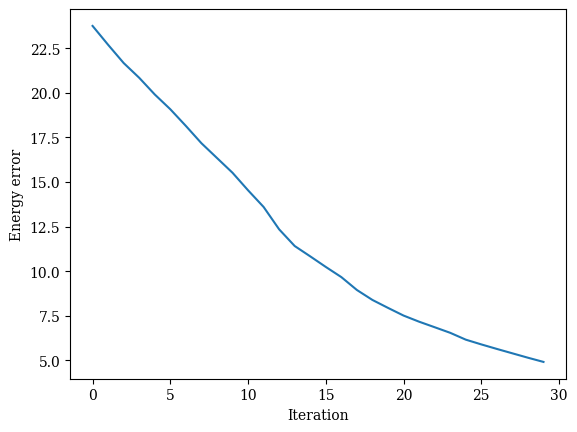

In [16]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [17]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [18]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [19]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

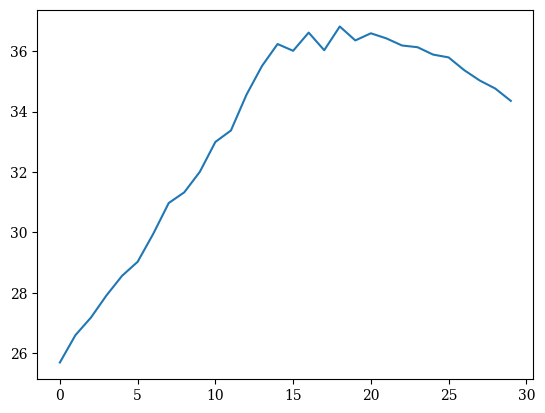

In [20]:
fig, ax = plt.subplots()
ax.plot(simualtor_errors)

## Carry out SQD.

In [ ]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [ ]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sampler.run([to_run], shots=30_000)
    job = sim.run(to_run)
    # bit_array = job.result()[0].data.meas
    # bit_array = job.result().data().meas
    counts = job.result().data()['counts']
    bit_array = BitArray.from_counts(counts)
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 4, 'rx': 2, 'h': 2, 'barrier': 2, 'rz': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 8, 'rx': 4, 'h': 4, 'barrier': 3, 'rz': 2})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 12, 'rx': 6, 'h': 6, 'barrier': 4, 'rz': 3})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 16, 'x': 15, 'rx': 8, 'h': 8, 'barrier': 5, 'rz': 4})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 20, 'x': 15, 'rx': 10, 'h': 10, 'barrier': 6, 'rz': 5})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 24, 'x': 15, 'rx': 12, 'h': 12, 'barrier': 7, 'rz': 6})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 28, 'x': 15, 'rx': 14, 'h': 14, 'barrier': 8, 'rz': 7})
On circuit 7/30
Gate counts (w

In [ ]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

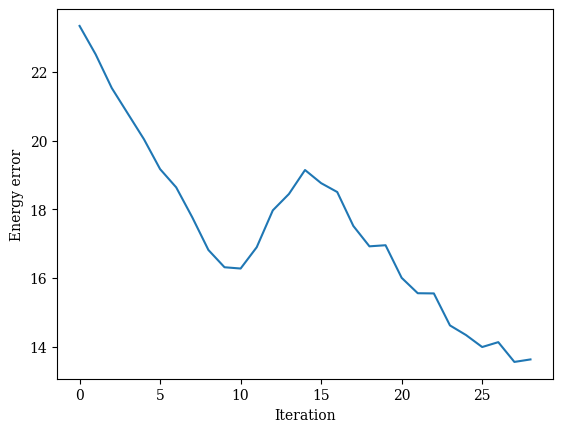

In [ ]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [ ]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

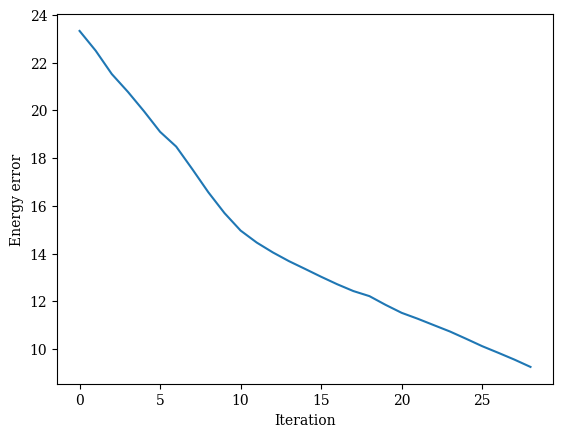

In [ ]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

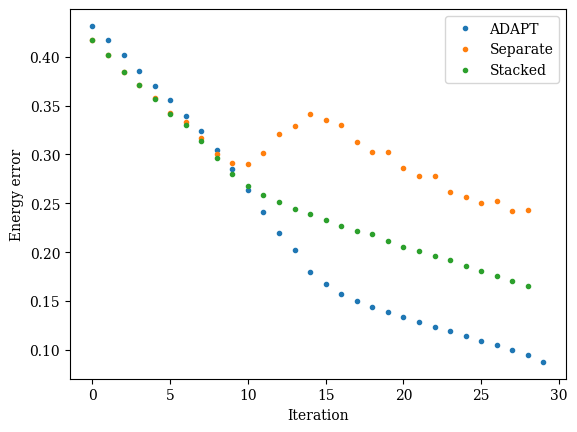

In [ ]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()